### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [1]:
import os
os.getcwd()

'C:\\Users\\User\\Downloads'

In [1]:
import pandas as pd
import numpy as np

def read_fmnist_csv(dataset):
    df = pd.read_csv(f'{dataset}')
    return df.drop(columns=['label']).to_numpy(), df['label'].to_numpy()

def load_data():
    return read_fmnist_csv('fashion-mnist_train.csv'), read_fmnist_csv('fashion-mnist_test.csv')

(x_train_pics, y_train), (x_test_pics, y_test) = load_data()

In [2]:
#from keras.datasets import fashion_mnist
#(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [3]:
from sklearn.metrics.pairwise import paired_cosine_distances
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from random import randint
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
import time



class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.scaler = StandardScaler()
        
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        X_new = self.scaler.fit_transform(X)

        if self.use_PCA==True:
          self.PCA = PCA(n_components=self.new_dim).fit(X_new)
          X = self.PCA.transform(X_new)
        else: X = X_new

        rand_1 = [randint(0, X.shape[0]-1) for i in range(10**6)]
        rand_2 = [randint(0, X.shape[0]-1) for i in range(10**6)]

        sigma = np.sqrt(np.median(np.sum((X[rand_1] - X[rand_2])**2, axis=1)))

        self.W = np.random.normal(0, 1/sigma, size=(X.shape[1], self.n_features))
        self.B = np.random.uniform(-np.pi, np.pi, self.n_features)

        PHI = np.cos(X@self.W + self.B)

        if self.classifier=='logreg':

          self.model = LogisticRegression(random_state=0)
          self.model.fit(PHI,y)  

        elif self.classifier=='svm':

          self.model = SVC(random_state=0, kernel='linear')
          self.model.fit(PHI,y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_new = self.scaler.transform(X)

        if self.use_PCA==True:
          X = self.PCA.transform(X_new)
        else: X = X_new

        PHI = np.cos(X@self.W + self.B)

        self.model.predict_proba(PHI)

        return self

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_new = self.scaler.transform(X)

        if self.use_PCA==True:
          X = self.PCA.transform(X_new)
        else: X = X_new

        PHI = np.cos(X@self.W + self.B)
        pred = self.model.predict(PHI)

        return pred

In [8]:
st = time.time()
RFF = RFFPipeline()
RFF.fit(x_train, y_train)
preds = RFF.predict(x_test)
et = time.time()
print(f'Accuracy score is:{metrics.accuracy_score(y_test, preds)}. Time of execution is: {np.round(et-st)} sec')

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score is:0.8643. Time of execution is: 68.0 sec


__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [9]:
#Линейный SVM со случайными признаками (PCA + RFF)
st = time.time()
SVM_lin_various = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier='svm')
SVM_lin_various.fit(x_train, y_train)
preds = SVM_lin_various.predict(x_test)
et = time.time()
print(f'Accuracy score is:{metrics.accuracy_score(y_test, preds)}. Time of execution is: {np.round(et-st)} sec')

Accuracy score is:0.8858. Time of execution is: 792.0 sec


In [6]:
#Линейный SVM на исходных данных (без RFF и PCA)
st = time.time()
sc_svm = StandardScaler()

sc_train = sc_svm.fit_transform(x_train)
sc_test = sc_svm.fit_transform(x_test)

SVM_lin_raw = SVC(random_state=0, kernel='linear')
SVM_lin_raw.fit(sc_train, y_train)
preds = SVM_lin_raw.predict(sc_test)
et = time.time()
print(f'Accuracy score is:{metrics.accuracy_score(y_test, preds)}. Time of execution is: {np.round(et-st)} sec')

Accuracy score is:0.845. Time of execution is: 2035.0 sec


In [7]:
#Ядровой SVM на исходных данных (без RFF и PCA)
st = time.time()
SVM_ker_raw = SVC(random_state=0, kernel='rbf')
SVM_ker_raw.fit(sc_train[0:20000], y_train[0:20000])
preds = SVM_ker_raw.predict(sc_test)
et = time.time()
print(f'Accuracy score is:{metrics.accuracy_score(y_test, preds)}. Time of execution is: {np.round(et-st)} sec')

Accuracy score is:0.8776. Time of execution is: 182.0 sec


In [4]:
!pip3 install catboost

In [9]:
#PCA + boosting
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report

st = time.time()
scale = StandardScaler()

sc_train = scale.fit_transform(x_train)
sc_test = scale.fit_transform(x_test)

X_train = PCA(n_components=50).fit_transform(sc_train)
X_test = PCA(n_components=50).fit_transform(sc_test)

boost = CatBoostClassifier()
grid = {
    'iterations': [100, 200, 300, 400, 500],
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search_result = boost.grid_search(grid,
                                       X=X_train,
                                       y=y_train)
boost.fit(X_train, y_train)
preds = boost.predict(X_test)
et = time.time()

0:	learn: 1.9550946	test: 1.9558830	best: 1.9558830 (0)	total: 455ms	remaining: 45s
1:	learn: 1.7618306	test: 1.7671815	best: 1.7671815 (1)	total: 935ms	remaining: 45.8s
2:	learn: 1.6143803	test: 1.6222481	best: 1.6222481 (2)	total: 1.39s	remaining: 45s
3:	learn: 1.4908770	test: 1.5005611	best: 1.5005611 (3)	total: 1.86s	remaining: 44.6s
4:	learn: 1.3990595	test: 1.4091284	best: 1.4091284 (4)	total: 2.32s	remaining: 44.1s
5:	learn: 1.3179589	test: 1.3290730	best: 1.3290730 (5)	total: 2.78s	remaining: 43.6s
6:	learn: 1.2520457	test: 1.2628394	best: 1.2628394 (6)	total: 3.25s	remaining: 43.2s
7:	learn: 1.1905368	test: 1.2020903	best: 1.2020903 (7)	total: 3.74s	remaining: 43s
8:	learn: 1.1424528	test: 1.1544882	best: 1.1544882 (8)	total: 4.19s	remaining: 42.4s
9:	learn: 1.0975854	test: 1.1101879	best: 1.1101879 (9)	total: 4.66s	remaining: 41.9s
10:	learn: 1.0536697	test: 1.0668175	best: 1.0668175 (10)	total: 5.11s	remaining: 41.3s
11:	learn: 1.0171262	test: 1.0307432	best: 1.0307432 (11)	

In [10]:
print(f'Accuracy score is:{metrics.accuracy_score(y_test, preds)}. Time of execution is: {np.round(et-st)} sec')

Accuracy score is:0.7405. Time of execution is: 4606.0 sec


**Линейный SVM на случайных данных (PCA+RFF) VS Линейный SVM на исходных данных (без PCA+RFF)**

Accuracy score на 0.04 выше в модели с преобразованными данными, чем с сырыми данными. Также время выполнения кода в случае с классом Pipeline значительно меньше обычного SVM в приблизительно 2.5 раза.

**Линейный SVM на случайных данных (PCA+RFF) VS Ядровой SVM на исходных данных (без PCA+RFF)**

Так как обучение ядрового SVM занимает большое количество времени, ограничил тренировочную выборку 20000 объектами.
Accuracy score на 0.008 выше в linear SVM с преобразованными данными, чем Kernel SVM с сырыми данными. Что является несущественным различием. Также время выполнения кода в случае с ядровым SVM значительно меньше линейного SVM в приблизительно 4.3 раза, однако надо принять во внимание то, что в ядровом случаем использовались только первые 20000 объектов, т.е. 1/3 от изначальной выборки.

**Catboost with grid_search for tuning hyperparameters**

Catboost показал наихудший результат среди использованных моделей. Accuracy модели едва превышает **0.704**, также из-за использования тюнинга гиперпараметров выполнение кода заняло очень много времени.

In [10]:
#Логрег с RFF без PCA
st = time.time()
log_RFF = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, classifier='logreg')
log_RFF.fit(x_train, y_train)
preds = log_RFF.predict(x_test)
et = time.time()
print(f'Accuracy score is:{metrics.accuracy_score(y_test, preds)}. Time of execution is: {np.round(et-st)} sec')

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score is:0.8676. Time of execution is: 620.0 sec


In [11]:
#Линейный SVM с RFF без PCA
st = time.time()
SVM_lin_RFF = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, classifier='svm')
SVM_lin_RFF.fit(x_train, y_train)
preds = SVM_lin_RFF.predict(x_test)
et = time.time()
print(f'Accuracy score is:{metrics.accuracy_score(y_test, preds)}. Time of execution is: {np.round(et-st)} sec')

Accuracy score is:0.8683. Time of execution is: 1332.0 sec


__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

**1. Помогает ли предварительное понижение размерности с помощью PCA?**

Для этого сравним две пары модели, запущенные выше:

**1) Логрег с PCA VS Логрег без PCA**

_Accuracy_:   0.8643 < 0.8676

_Time_:       68 sec < 620 sec

**2) SVM с PCA VS SVM без PCA**

_Accuracy_:   0.8858 > 0.8683

_Time_:      792 sec < 1332 sec

PCA значительно сокращает время выполнения кода. Однако в плане accuracy нельзя сказать однозначно, так как в логреге с PCA он незначительно меньше, чем без PCA, а в SVM вариант с PCA показывает более высокое качество, чем вариант без PCA.

**Предварительное понижение размерности с помощью PCA помогает**

**2. Как зависит итоговое качество от n_features? Выходит ли оно на плато?**

Для этого прогоним несколько моделей с разным параметром n_features и нарисуем график зависимости качества модели от этого параметра.

In [17]:
import warnings
warnings.filterwarnings('ignore')
experim = [50, 100, 300, 500, 1200, 1500]
result = []
for i in experim:
    logreg = RFFPipeline(n_features=i)
    logreg.fit(x_train, y_train)
    preds = logreg.predict(x_test)
    result.append(metrics.accuracy_score(y_test, preds))
    print(f'For n_features = {i}: accuracy = {metrics.accuracy_score(y_test, preds)}')

For n_features = 50: accuracy = 0.8175
For n_features = 100: accuracy = 0.8385
For n_features = 300: accuracy = 0.8547
For n_features = 500: accuracy = 0.8607
For n_features = 1200: accuracy = 0.8623
For n_features = 1500: accuracy = 0.8635


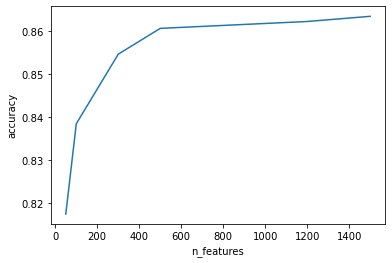

In [18]:
import matplotlib.pyplot as plt
plt.plot(experim, result)
plt.ylabel('accuracy')
plt.xlabel('n_features')
plt.show()

**Вывод:** с ростом n_features растет accuracy модели. При первых итерациях темп роста качества высокий, однако при более поздних итерациях он снижается, accuracy растет медленно. Следовательно, мы вышли на плато.

**3. Важно ли какую модель обучать?**

Для этого сравним две пары моделей:

**1) linear SVM PCA+RFF VS logreg PCA+RFF**

_Accuracy_:   0.8858 > 0.8643

_Time_:       792 sec > 68 sec

**2) linear SVM без PCA VS logreg без PCA**

_Accuracy_:   0.8683 > 0.8676

_Time_:      1332 sec > 620 sec

В обоих случаях модель с SVM показывает лучшее качество, чем модель с logreg. Однако время, затрачиваемое на SVM-модели, гораздо больше времени для logreg-моделей. 

**Вывод:** для лучшего качества надо использовать SVM. Для более быстрой работы - logreg.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪